## 使用torch-directml在CIFAR10数据集下训练ResNet网络
ResNet网络是CNN网络从浅层转向深层的标志，它解决了CNN网络随深度增大导致的梯度爆炸、梯度消失和学习困难等一系列问题。下面笔者会在CIFAR10数据集上训练ResNet，作为torch-directml的使用示例。

### 1. 数据集准备
首先笔者将使用下面的代码下载CIFAR10数据集：

In [1]:
import torch
import torchvision

trans = torchvision.transforms.ToTensor()

training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=trans, download=True)
validating_set = torchvision.datasets.CIFAR10('./data', train=False, transform=trans, download=True)

Files already downloaded and verified
Files already downloaded and verified


简单看看训练集和测试集中各有几条数据：

In [2]:
print(len(training_set), len(validating_set))

print(validating_set[0][0].shape)
print(type(validating_set[0][1]))

50000 10000
torch.Size([3, 32, 32])
<class 'int'>


如果数据集下载正常，那么训练集中将有50000条数据，测试集中有10000条数据。接下来使用`torch.utils.data.DataLoader`来加载数据集：

In [3]:
BATCH_SIZE = 256

train_dataloader = torch.utils.data.dataloader.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.dataloader.DataLoader(validating_set, batch_size=BATCH_SIZE, shuffle=True)

接下来通过查看第一批数据来验证数据是否正常加载：

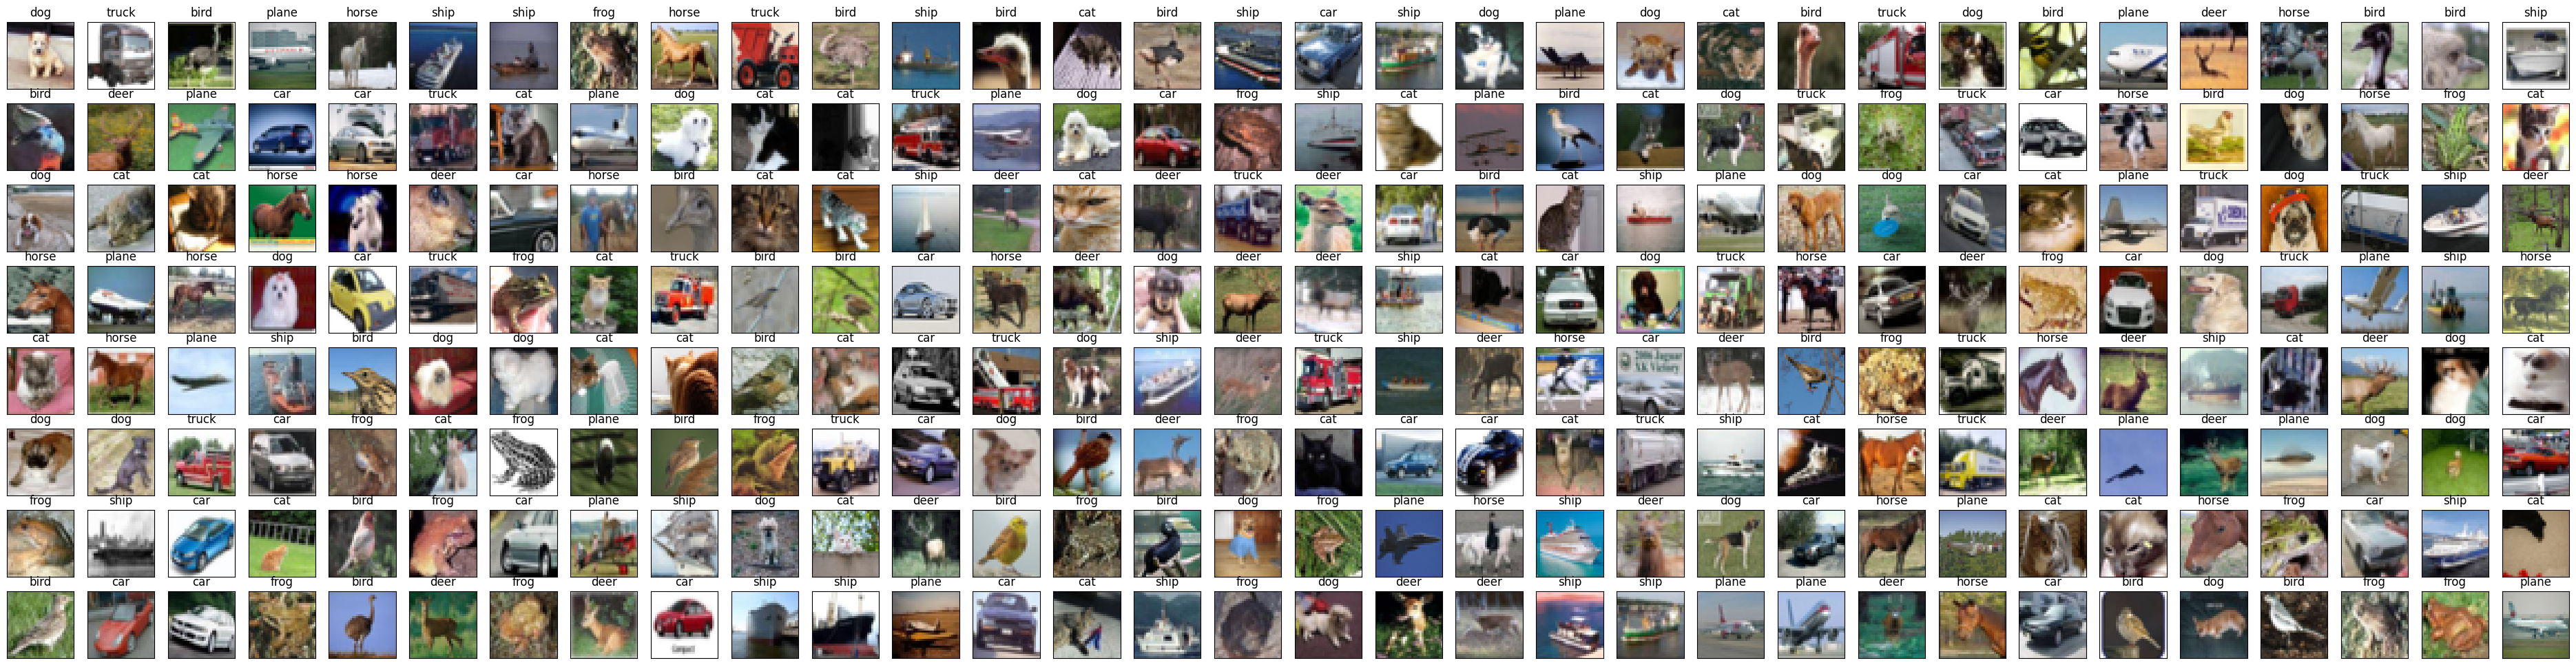

In [4]:
from matplotlib import pyplot as plt

TEXT_LABELS = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_cifar10_labels(labels):
    return [TEXT_LABELS[int(i)] for i in labels]

def show_dataset_items(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            img = img.permute(1, 2, 0)
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.show()

X, y = next(iter(train_dataloader))
show_dataset_items(X, 8, int(BATCH_SIZE / 8), get_cifar10_labels(y))

### 2. 构建ResNet
由于笔者选择的CIFAR10数据集规模较小，使用的ResNet规模可以不用那么大。这里将选择ResNet-34来训练。

In [5]:
from torch import nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, blocks_num, num_classes, include_top=True):
        super().__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)自适应
            self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    
    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion)
            )
        
        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x

def resnet34(num_classes=10, include_top=True):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)

### 3. 训练模型

#### 3.1 定义超参数

In [6]:
import torch_directml

LR = 0.001
EPOCHS = 50

device = torch_directml.device()
print('select device', device)

model = resnet34(num_classes=10)
model.to(device=device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

select device privateuseone:0


#### 3.2 开始训练

In [7]:
losses = []
accurs = []

for epoch in range(EPOCHS):
    model.train()
    for i, (imgs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().data.item())
        if (i + 1) % 100 == 0:
            print('Epoch : %d/%d, Iter : %d/%d, Loss : %.4f' % (
                epoch + 1, EPOCHS,
                i + 1, len(training_set) // BATCH_SIZE,
                loss.data.item()
            ))
    
    model.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        for (val_imgs, val_lables) in test_dataloader:
             outputs = model(val_imgs.to(device))
             predict_y = torch.max(outputs, dim=1)[1]
             acc += (predict_y == val_lables.to(device)).sum().item()
        val_accurate = acc / len(validating_set)
        
        accurs.append(val_accurate)
        print('[epoch %d] test_accuracy: %.3f' %
              (epoch + 1, val_accurate))

print('Finished Training')

Epoch : 1/50, Iter : 100/195, Loss : 1.4844
[epoch 1] test_accuracy: 0.526
Epoch : 2/50, Iter : 100/195, Loss : 1.0447
[epoch 2] test_accuracy: 0.570
Epoch : 3/50, Iter : 100/195, Loss : 0.8541
[epoch 3] test_accuracy: 0.547
Epoch : 4/50, Iter : 100/195, Loss : 0.7280
[epoch 4] test_accuracy: 0.602
Epoch : 5/50, Iter : 100/195, Loss : 0.6486
[epoch 5] test_accuracy: 0.634
Epoch : 6/50, Iter : 100/195, Loss : 0.6046
[epoch 6] test_accuracy: 0.693
Epoch : 7/50, Iter : 100/195, Loss : 0.5035
[epoch 7] test_accuracy: 0.690
Epoch : 8/50, Iter : 100/195, Loss : 0.4356
[epoch 8] test_accuracy: 0.657
Epoch : 9/50, Iter : 100/195, Loss : 0.3722
[epoch 9] test_accuracy: 0.682
Epoch : 10/50, Iter : 100/195, Loss : 0.3280
[epoch 10] test_accuracy: 0.711
Epoch : 11/50, Iter : 100/195, Loss : 0.2186
[epoch 11] test_accuracy: 0.630
Epoch : 12/50, Iter : 100/195, Loss : 0.2150
[epoch 12] test_accuracy: 0.688
Epoch : 13/50, Iter : 100/195, Loss : 0.2240
[epoch 13] test_accuracy: 0.677
Epoch : 14/50, It

绘制出loss曲线和accuracy曲线，观察训练是否收敛：

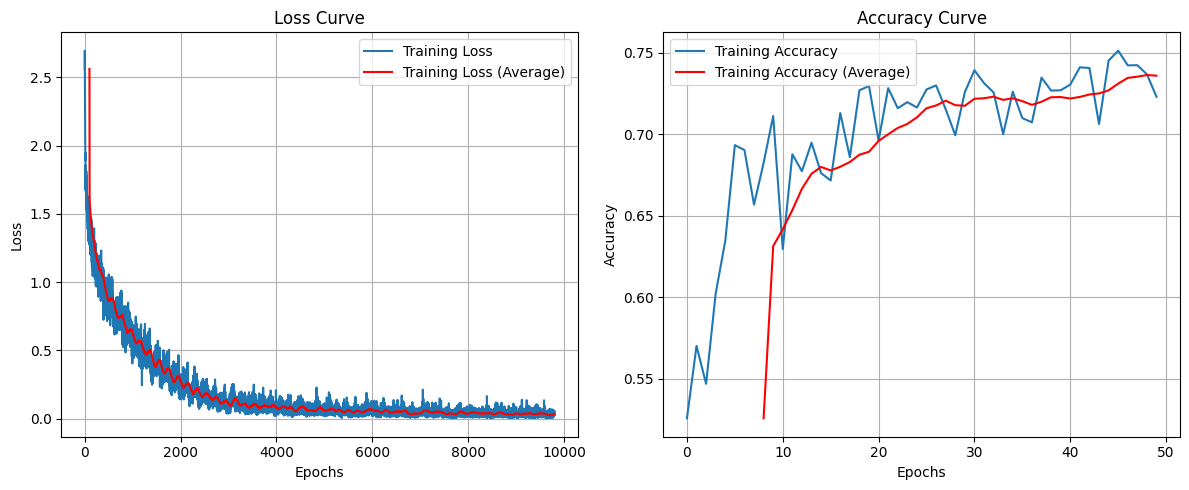

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 定义移动平均函数
def moving_average(data, window_size=3):
    # 计算移动平均
    smoothed_data = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    # 在平滑数据的开头补充第一个数据点
    smoothed_data = np.insert(smoothed_data, 0, data[0])
    return smoothed_data

# 绘制损失曲线
plt.figure(figsize=(12, 5))

# 绘制训练集损失曲线
x = range(len(losses))
losses_smoth = moving_average(losses, window_size=100)
plt.subplot(1, 2, 1)  # 1行2列的第1个子图
plt.plot(x, losses, label='Training Loss')
plt.plot(x[98:], losses_smoth, label='Training Loss (Average)', color='red')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 绘制准确率曲线
plt.subplot(1, 2, 2)  # 1行2列的第2个子图
x = range(len(accurs))
accurs_smoth = moving_average(accurs, window_size=10)
plt.plot(x, accurs, label='Training Accuracy')
plt.plot(x[8:], accurs_smoth, label='Training Accuracy (Average)', color='red')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 显示整个图像
plt.tight_layout()
plt.show()

从上面的曲线可以清晰的看到，模型是收敛的。接下来就可以把模型保持到本地文件中备用了：

In [23]:
torch.save(model.state_dict(), 'model/model_weights.pth')